In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time as time

import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device:{device}')

Device:cuda:0


In [3]:
class NN(nn.Module):
    def __init__(self,layers):
        super().__init__()

        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction = 'mean')
        self.layers = layers

        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])



        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)



    def forward(self,x,y,z,t):
        a = torch.cat([x,y,z,t], dim = 1)

        for i in range(len(self.layers)-2):
            L = self.linears[i](a)
            a = self.activation(L)

        b = self.linears[-1](a)

        return b

In [4]:
layers = np.array([4,64,64,64,64,64,1])
net_T = NN(layers).to(device)

/home/soumik/miniconda3/envs/pyro_env/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Normalize Inputs and Outputs


def net_T_norm(x,y,z,t):
    x_n = 2*(x/0.04)  - 1.0
    y_n = 2*(y/0.01) - 1.0
    z_n = 2*(z/0.006) - 1.0
    t_n = 2*(t/3.0) - 1.0

    dT = net_T(x_n,y_n,z_n,t_n)
    dT = F.softplus(dT)

    T = dT + 298.0


    return T

In [6]:
###### Collocation Points

## Near Top

t = torch.linspace(0.0,3.0,31).reshape(-1,1)
t = torch.tensor(t, dtype = torch.float32, device = device)

x_near_top = torch.linspace(0.0,0.04,41).reshape(-1,1)
x_near_top = torch.tensor(x_near_top, dtype = torch.float32, device = device)

y_near_top = torch.linspace(0.0,0.01,11).reshape(-1,1)
y_near_top = torch.tensor(y_near_top, dtype = torch.float32, device = device)

z_near_top = torch.linspace(0.005,0.006,2).reshape(-1,1)
z_near_top = torch.tensor(z_near_top, dtype = torch.float32, device = device)




# Meshgrid for near top region

X_near_top,Y_near_top,Z_near_top,t_near_top = torch.meshgrid(x_near_top.squeeze(),y_near_top.squeeze(),z_near_top.squeeze(),t.squeeze(), indexing = 'ij')

X_near_top = X_near_top.reshape(-1,1).requires_grad_(True)
Y_near_top = Y_near_top.reshape(-1,1).requires_grad_(True)
Z_near_top = Z_near_top.reshape(-1,1).requires_grad_(True)
t_near_top = t_near_top.reshape(-1,1).requires_grad_(True)













##### Points for other region


x_other = torch.linspace(0.0,0.04,9).reshape(-1,1)
x_other = torch.tensor(x_other, dtype = torch.float32, device = device)

y_other = torch.linspace(0.0,0.01,3).reshape(-1,1)
y_other = torch.tensor(y_other, dtype = torch.float32, device = device)


z_other = torch.tensor([0.0], dtype = torch.float32, device = device).reshape(-1,1)


# Meshgrid for other region

X_other,Y_other,Z_other,t_other = torch.meshgrid(x_other.squeeze(),y_other.squeeze(),z_other.squeeze(),t.squeeze(), indexing = 'ij')

X_other = X_other.reshape(-1,1).requires_grad_(True)
Y_other = Y_other.reshape(-1,1).requires_grad_(True)
Z_other = Z_other.reshape(-1,1).requires_grad_(True)
t_other = t_other.reshape(-1,1).requires_grad_(True)







##### Initial Points

t0 = torch.zeros_like(t[:1])

# Near top IC
X_near_top_ic,Y_near_top_ic,Z_near_top_ic,t_near_top_ic = torch.meshgrid(x_near_top.squeeze(),y_near_top.squeeze(),z_near_top.squeeze(),t0.squeeze(), indexing = 'ij')

X_near_top_ic = X_near_top_ic.reshape(-1,1)
Y_near_top_ic = Y_near_top_ic.reshape(-1,1)
Z_near_top_ic = Z_near_top_ic.reshape(-1,1)
t_near_top_ic = t_near_top_ic.reshape(-1,1)


# Meshgrid for other region IC

X_other_ic,Y_other_ic,Z_other_ic,t_other_ic = torch.meshgrid(x_other.squeeze(),y_other.squeeze(),z_other.squeeze(),t0.squeeze(), indexing = 'ij')

X_other_ic = X_other_ic.reshape(-1,1)
Y_other_ic = Y_other_ic.reshape(-1,1)
Z_other_ic = Z_other_ic.reshape(-1,1)
t_other_ic = t_other_ic.reshape(-1,1)











/tmp/ipykernel_589665/3827276350.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3827276350.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_near_top = torch.tensor(x_near_top, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3827276350.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_near_top = torch.tensor(y_near_top, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3827276350.py:15: UserWarning: To copy construct f

In [7]:
# Generating Boundary Points


 # Top surface points
t = torch.linspace(0.0,3.0,31).reshape(-1,1)
t = torch.tensor(t, dtype = torch.float32, device = device)

x_top = torch.linspace(0.0,0.04,21).reshape(-1,1)
x_top = torch.tensor(x_top, dtype = torch.float32, device = device)

y_top = torch.linspace(0.0,0.01,6).reshape(-1,1)
y_top = torch.tensor(y_top, dtype = torch.float32, device = device)

z_top = torch.tensor([0.006], dtype = torch.float32, device = device).reshape(-1,1)


X_top, Y_top, Z_top, t_top = torch.meshgrid(x_top.squeeze(),y_top.squeeze(),z_top.squeeze(),t.squeeze(), indexing = 'ij')
X_top = X_top.reshape(-1,1)
Y_top = Y_top.reshape(-1,1)
Z_top = Z_top.reshape(-1,1).requires_grad_(True)
t_top = t_top.reshape(-1,1)




# Bottom Surface Points
    
# x_top, y_top, t_top are same as x_bottom, y_bottom, t_bottom. only z will change here.

z_bottom = torch.tensor([0.0], dtype = torch.float32, device = device).reshape(-1,1)


X_bottom, Y_bottom, Z_bottom, t_bottom = torch.meshgrid(x_top.squeeze(),y_top.squeeze(),z_bottom.squeeze(),t.squeeze(), indexing = 'ij')
X_bottom = X_bottom.reshape(-1,1)
Y_bottom = Y_bottom.reshape(-1,1)
Z_bottom = Z_bottom.reshape(-1,1)
t_bottom = t_bottom.reshape(-1,1)




# Side surface points (x=0)
# for this surface, x changes to 0, y same, z changes, t same

x_side_x0 = torch.tensor([0.0], dtype = torch.float32, device = device).reshape(-1,1)
z_side_x0 = torch.linspace(0.0,0.006,4).reshape(-1,1)
z_side_x0 = torch.tensor(z_side_x0, dtype = torch.float32, device = device)

X_side_x0, Y_side_x0, Z_side_x0, t_side_x0 = torch.meshgrid(x_side_x0.squeeze(),y_top.squeeze(), z_side_x0.squeeze(), t.squeeze(), indexing = 'ij')

X_side_x0 = X_side_x0.reshape(-1,1).requires_grad_(True)
Y_side_x0 = Y_side_x0.reshape(-1,1)
Z_side_x0 = Z_side_x0.reshape(-1,1)
t_side_x0 = t_side_x0.reshape(-1,1)




# Side surface (x = 40)
x_side_x40 = torch.tensor([0.04], dtype = torch.float32, device = device).reshape(-1,1)

X_side_x40, Y_side_x40, Z_side_x40, t_side_x40 = torch.meshgrid(x_side_x40.squeeze(),y_top.squeeze(), z_side_x0.squeeze(), t.squeeze(), indexing = 'ij')



X_side_x40 = X_side_x40.reshape(-1,1).requires_grad_(True)
Y_side_x40 = Y_side_x40.reshape(-1,1)
Z_side_x40 = Z_side_x40.reshape(-1,1)
t_side_x40 = t_side_x40.reshape(-1,1)



# Side surface (y = 0)

y_side_y0 = torch.tensor([0.0], dtype = torch.float32, device = device).reshape(-1,1)

X_side_y0, Y_side_y0, Z_side_y0, t_side_y0 = torch.meshgrid(x_top.squeeze(),y_side_y0.squeeze(), z_side_x0.squeeze(), t.squeeze(), indexing = 'ij')

X_side_y0 = X_side_y0.reshape(-1,1)
Y_side_y0 = Y_side_y0.reshape(-1,1).requires_grad_(True)
Z_side_y0 = Z_side_y0.reshape(-1,1)
t_side_y0 = t_side_y0.reshape(-1,1)


# Side surface (y = 10)

y_side_y10 = torch.tensor([0.01], dtype = torch.float32, device = device).reshape(-1,1)

X_side_y10, Y_side_y10, Z_side_y10, t_side_y10 = torch.meshgrid(x_top.squeeze(),y_side_y10.squeeze(), z_side_x0.squeeze(), t.squeeze(), indexing = 'ij')

X_side_y10 = X_side_y10.reshape(-1,1)
Y_side_y10 = Y_side_y10.reshape(-1,1).requires_grad_(True)
Z_side_y10 = Z_side_y10.reshape(-1,1)
t_side_y10 = t_side_y10.reshape(-1,1)

/tmp/ipykernel_589665/3992281550.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3992281550.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_top = torch.tensor(x_top, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3992281550.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_top = torch.tensor(y_top, dtype = torch.float32, device = device)
/tmp/ipykernel_589665/3992281550.py:47: UserWarning: To copy construct from a tensor, it is 

In [8]:
def bc_loss(X_top, Y_top, Z_top, t_top, X_bottom, Y_bottom, Z_bottom, t_bottom, X_side_x0, Y_side_x0,Z_side_x0, t_side_x0, X_side_x40, Y_side_x40,Z_side_x40, t_side_x40, X_side_y0,Y_side_y0, Z_side_y0, t_side_y0, X_side_y10,Y_side_y10, Z_side_y10, t_side_y10):
   








    #### Residual Calculations

    # Constants
    eta = 0.4
    P = 500.0
    r_b = 0.0015
    h = 20
    eps = 0.3
    sig = 5.67e-8
    v = 0.01
    k = 10.0


    # mm = 1e-3



    # Bottom residual (Dirichlet)

    res_bottom = net_T_norm(X_bottom,Y_bottom,Z_bottom,t_bottom) - 298.0
    loss_bottom = torch.mean(res_bottom**2)

    # Top residual
    T_top = net_T_norm(X_top, Y_top, Z_top, t_top)
    T_top_z = torch.autograd.grad(T_top, Z_top, torch.ones_like(T_top), create_graph=True)[0]
    # T_top_z_m = T_top_z * 1000.0

    xL = torch.clamp(0.0 + v * t_top, 0.0, 0.04)
    yL = 0.005

    # X_top_m = X_top * mm
    # Y_top_m = Y_top * mm

    # xL_m = xL * mm
    # yL_m = yL * mm

    # r_b_m = r_b * mm
    
    

    # d2_m = (X_top_m - xL_m)**2 + (Y_top_m - yL_m)**2
    d2 = (X_top - xL)**2 + (Y_top - yL)**2


    # q_laser = -((2*eta*P)/(torch.pi * r_b_m * r_b_m)) * torch.exp((-2*d2_m)/(r_b_m**2))
    q_laser = -((2*eta*P)/(torch.pi * r_b * r_b)) * torch.exp((-2*d2)/(r_b**2))
    q_conv_top = h*(T_top - 298.0)
    q_rad_top = sig*eps*(T_top**4 - 298.0**4)


    # res_top = (-k*T_top_z_m) - (q_laser + q_conv_top + q_rad_top)
    res_top = (-k*T_top_z) - (q_laser + q_conv_top + q_rad_top)

    q0 = (2*eta*P)/(torch.pi * r_b * r_b)

    res_top = res_top / q0
    loss_top = torch.mean(res_top**2)


    # Side residual x=0
    T_side_x0 = net_T_norm(X_side_x0, Y_side_x0, Z_side_x0, t_side_x0)
    T_side_x0_x = torch.autograd.grad(T_side_x0,X_side_x0,torch.ones_like(T_side_x0), create_graph=True)[0]
    # T_side_x0_x_m = T_side_x0_x * 1000.0

    q_conv_side_x0 = h*(T_side_x0 - 298.0)
    q_rad_side_x0 = sig*eps*(T_side_x0**4 - 298.0**4)

    # res_side_x0 = (k*T_side_x0_x_m) - (q_conv_side_x0 + q_rad_side_x0)
    res_side_x0 = (k*T_side_x0_x) - (q_conv_side_x0 + q_rad_side_x0)
    loss_side_x0 = torch.mean(res_side_x0**2)


    # Side residual x=40
    T_side_x40 = net_T_norm(X_side_x40, Y_side_x40, Z_side_x40, t_side_x40)
    T_side_x40_x = torch.autograd.grad(T_side_x40,X_side_x40,torch.ones_like(T_side_x40), create_graph=True)[0]
    # T_side_x40_x_m = T_side_x40_x * 1000.0

    q_conv_side_x40 = h*(T_side_x40 - 298.0)
    q_rad_side_x40 = sig*eps*(T_side_x40**4 - 298.0**4)

    # res_side_x40 = -(k*T_side_x40_x_m) - (q_conv_side_x40 + q_rad_side_x40)
    res_side_x40 = -(k*T_side_x40_x) - (q_conv_side_x40 + q_rad_side_x40)
    loss_side_x40 = torch.mean(res_side_x40**2)



    # Side residual y=0
    T_side_y0 = net_T_norm(X_side_y0, Y_side_y0, Z_side_y0, t_side_y0)
    T_side_y0_y = torch.autograd.grad(T_side_y0,Y_side_y0,torch.ones_like(T_side_y0), create_graph=True)[0]
    # T_side_y0_y_m = T_side_y0_y * 1000.0

    q_conv_side_y0 = h*(T_side_y0 - 298.0)
    q_rad_side_y0 = sig*eps*(T_side_y0**4 - 298.0**4)

    # res_side_y0 = (k*T_side_y0_y_m) - (q_conv_side_y0 + q_rad_side_y0)
    res_side_y0 = (k*T_side_y0_y) - (q_conv_side_y0 + q_rad_side_y0)
    loss_side_y0 = torch.mean(res_side_y0**2)



    # Side residual y=10
    T_side_y10 = net_T_norm(X_side_y10, Y_side_y10, Z_side_y10, t_side_y10)
    T_side_y10_y = torch.autograd.grad(T_side_y10,Y_side_y10,torch.ones_like(T_side_y10), create_graph=True)[0]
    # T_side_y10_y_m = T_side_y10_y * 1000.0

    q_conv_side_y10 = h*(T_side_y10 - 298.0)
    q_rad_side_y10 = sig*eps*(T_side_y10**4 - 298.0**4)

    # res_side_y10 = -(k*T_side_y10_y_m) - (q_conv_side_y10 + q_rad_side_y10)
    res_side_y10 = -(k*T_side_y10_y) - (q_conv_side_y10 + q_rad_side_y10)
    loss_side_y10 = torch.mean(res_side_y10**2)



    loss_bc = loss_top + loss_bottom + loss_side_x0 + loss_side_x40 + loss_side_y0 + loss_side_y10


    return loss_bc 




In [9]:
def ic_loss(X_near_top_ic,Y_near_top_ic,Z_near_top_ic,t_near_top_ic,X_other_ic,Y_other_ic,Z_other_ic,t_other_ic):
    T_nt_ic = net_T_norm(X_near_top_ic,Y_near_top_ic,Z_near_top_ic,t_near_top_ic)
    T_other_ic = net_T_norm(X_other_ic,Y_other_ic,Z_other_ic,t_other_ic)

    res_nt_ic = T_nt_ic - 298.0
    loss_nt_ic = torch.mean(res_nt_ic**2)

    res_other_ic = T_other_ic - 298.0
    loss_other_ic = torch.mean(res_other_ic ** 2)


    loss_ic = loss_nt_ic + loss_other_ic

    return loss_ic
    

In [10]:
def pde_loss(X_near_top,Y_near_top,Z_near_top,t_near_top,X_other,Y_other,Z_other,t_other):
    rho = 8000.0
    c_p = 500.0
    k = 10.0


    T_near_top = net_T_norm(X_near_top,Y_near_top,Z_near_top,t_near_top)
    T_nt_x = torch.autograd.grad(T_near_top,X_near_top, torch.ones_like(T_near_top), create_graph=True)[0]
    T_nt_x_x = torch.autograd.grad(T_nt_x,X_near_top, torch.ones_like(T_nt_x), create_graph=True)[0]
    T_nt_y = torch.autograd.grad(T_near_top,Y_near_top, torch.ones_like(T_near_top), create_graph=True)[0]
    T_nt_y_y = torch.autograd.grad(T_nt_y,Y_near_top, torch.ones_like(T_nt_y), create_graph=True)[0]
    T_nt_z = torch.autograd.grad(T_near_top,Z_near_top, torch.ones_like(T_near_top), create_graph=True)[0]
    T_nt_z_z = torch.autograd.grad(T_nt_z,Z_near_top, torch.ones_like(T_nt_z), create_graph=True)[0]
    T_nt_t = torch.autograd.grad(T_near_top,t_near_top, torch.ones_like(T_near_top), create_graph=True)[0]

    # lap_T_nt_m2 = (T_nt_x_x + T_nt_y_y + T_nt_z_z) * 1e6
    lap_T_nt = (T_nt_x_x + T_nt_y_y + T_nt_z_z)


    # res_pde_nt = T_nt_t - ((k*lap_T_nt_m2)/(rho*c_p))
    res_pde_nt = T_nt_t - ((k*lap_T_nt)/(rho*c_p))
    loss_pde_nt = torch.mean(res_pde_nt ** 2)


    T_other = net_T_norm(X_other,Y_other,Z_other,t_other)
    T_other_x = torch.autograd.grad(T_other,X_other,torch.ones_like(T_other), create_graph=True)[0]
    T_other_x_x = torch.autograd.grad(T_other_x, X_other, torch.ones_like(T_other_x),create_graph=True)[0]
    T_other_y = torch.autograd.grad(T_other,Y_other,torch.ones_like(T_other), create_graph=True)[0]
    T_other_y_y = torch.autograd.grad(T_other_y, Y_other, torch.ones_like(T_other_y),create_graph=True)[0]
    T_other_z = torch.autograd.grad(T_other,Z_other,torch.ones_like(T_other), create_graph=True)[0]
    T_other_z_z = torch.autograd.grad(T_other_z, Z_other, torch.ones_like(T_other_z),create_graph=True)[0]
    T_other_t = torch.autograd.grad(T_other,t_other,torch.ones_like(T_other), create_graph=True)[0]


    # lap_T_other_m2 = (T_other_x_x + T_other_y_y + T_other_z_z) * 1e6

    lap_T_other = (T_other_x_x + T_other_y_y + T_other_z_z)

    # res_pde_other = T_other_t - ((k*lap_T_other_m2)/(rho*c_p))
    res_pde_other = T_other_t - ((k*lap_T_other)/(rho*c_p))
    loss_pde_other = torch.mean(res_pde_other**2)



    loss_pde = loss_pde_nt + loss_pde_other


    return loss_pde



In [11]:
optimizer = torch.optim.Adam(net_T.parameters(), lr = 0.001 )

In [12]:
torch.manual_seed(42)

/home/soumik/miniconda3/envs/pyro_env/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [13]:
if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [14]:
start_time = time.time()

num_epochs = 20000

total_loss_list = []

loss_bc_hist = []
loss_ic_hist = []
loss_pde_hist = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    

    # total_loss = add_losses()
    loss_bc = bc_loss(X_top, Y_top, Z_top, t_top, X_bottom, Y_bottom, Z_bottom, t_bottom, X_side_x0, Y_side_x0,Z_side_x0, t_side_x0, X_side_x40, Y_side_x40,Z_side_x40, t_side_x40, X_side_y0,Y_side_y0, Z_side_y0, t_side_y0, X_side_y10,Y_side_y10, Z_side_y10, t_side_y10)
    loss_ic = ic_loss(X_near_top_ic,Y_near_top_ic,Z_near_top_ic,t_near_top_ic,X_other_ic,Y_other_ic,Z_other_ic,t_other_ic)
    loss_pde = pde_loss(X_near_top,Y_near_top,Z_near_top,t_near_top,X_other,Y_other,Z_other,t_other)

    total_loss = loss_bc + loss_ic + loss_pde

    total_loss.backward()

    
    

    optimizer.step()
    
    

    
    total_loss_list.append(total_loss.item())
    loss_bc_hist.append(loss_bc.item())
    loss_ic_hist.append(loss_ic.item())
    loss_pde_hist.append(loss_pde.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}:  total loss={total_loss.item():.3e}")
        print(loss_bc.item(), loss_ic.item(), loss_pde.item())

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

Epoch 0:  total loss=5.220e+03
5219.2060546875 0.9648361206054688 0.0010860260808840394
Epoch 500:  total loss=6.337e+00
5.793198585510254 0.5437719225883484 0.00022947364777792245
Epoch 1000:  total loss=1.394e+00
0.8874194025993347 0.5067015290260315 0.00017969652253668755
Epoch 1500:  total loss=9.906e-01
0.5088651776313782 0.48153579235076904 0.00018820942204911262
Epoch 2000:  total loss=8.463e-01
0.3909130394458771 0.4551587700843811 0.00021372304763644934
Epoch 2500:  total loss=6.887e-01
0.315360963344574 0.3731764853000641 0.00014931097393855453
Epoch 3000:  total loss=6.019e-01
0.2527424991130829 0.3489149212837219 0.00020674490951932967
Epoch 3500:  total loss=4.631e-01
0.19263194501399994 0.270234078168869 0.00018591078696772456
Epoch 4000:  total loss=3.792e-01
0.17072102427482605 0.20829638838768005 0.00016122245870064944
Epoch 4500:  total loss=3.150e-01
0.1255359947681427 0.18928807973861694 0.0002147446502931416
Epoch 5000:  total loss=2.295e-01
0.09299707412719727 0.1

In [15]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  1066.60 MB


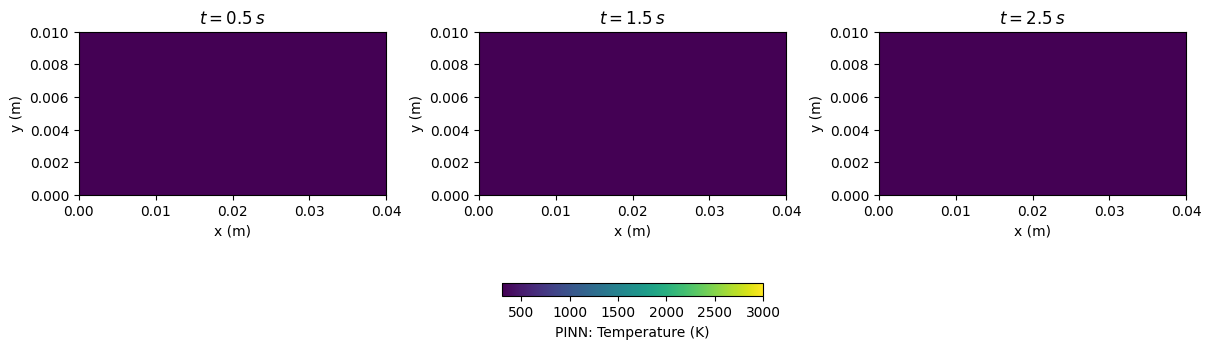

In [16]:
x = torch.linspace(0.0, 0.04, 400, device=device).reshape(-1, 1)
y = torch.linspace(0.0, 0.01, 100, device=device).reshape(-1, 1)

X, Y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing="ij")
Xf = X.reshape(-1, 1)
Yf = Y.reshape(-1, 1)
Zf = torch.full_like(Xf, float(0.006))


fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)

net_T.eval()


times = [0.5, 1.5, 2.5]

with torch.no_grad():
    for ax, tval in zip(axes, times):
        tf = torch.full_like(Xf, float(tval))
        T_pred = net_T_norm(Xf, Yf, Zf, tf).reshape(400,100).detach().cpu().numpy()


        im = ax.imshow(T_pred.T, origin = 'lower', aspect = 'auto', extent=[0, 0.04, 0, 0.01], vmin = 300, vmax = 3000)
        ax.set_title(rf"$t={tval}\,s$")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("y (m)")

cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.08, pad=0.25)
cbar.set_label("PINN: Temperature (K)")


plt.show()





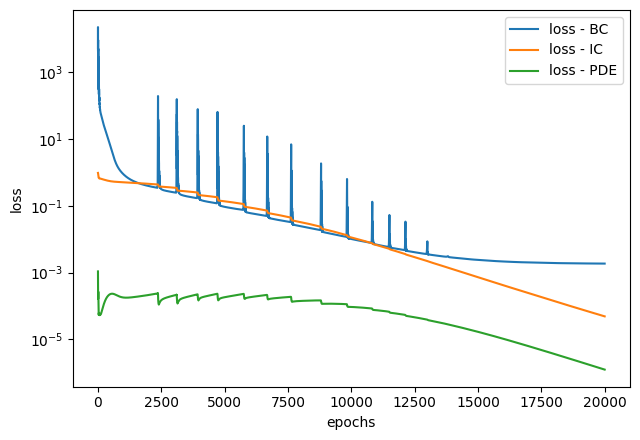

In [17]:
epochs = np.arange(len(loss_bc_hist))


plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, loss_bc_hist, label='loss - BC')
plt.plot(epochs, loss_ic_hist, label='loss - IC')
plt.plot(epochs, loss_pde_hist, label='loss - PDE')


plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()